In [ ]:
# task 1

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.read_csv('../StudentsPerformance.csv')

print(df.columns)
print(df.shape)

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')
(1000, 8)


In [18]:
df['mean_score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)

label_encoders = {}
categorical_cols = ['gender', 'race/ethnicity', 'parental level of education', 
                    'lunch', 'test preparation course']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

    # Вывод расшифровки значений
    print(f"Расшифровка для '{col}':")
    for idx, class_ in enumerate(le.classes_):
        print(f"  {idx}: {class_}")

In [19]:
numerical_cols = ['math score', 'reading score', 'writing score', 'mean_score']
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

threshold = df['mean_score'].median()
df['target'] = (df['mean_score'] >= threshold).astype(int)

X = df.drop(columns=['target', 'mean_score'])
y = df['target']

In [20]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [21]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

Text(0, 0.5, 'Principal Component 2')

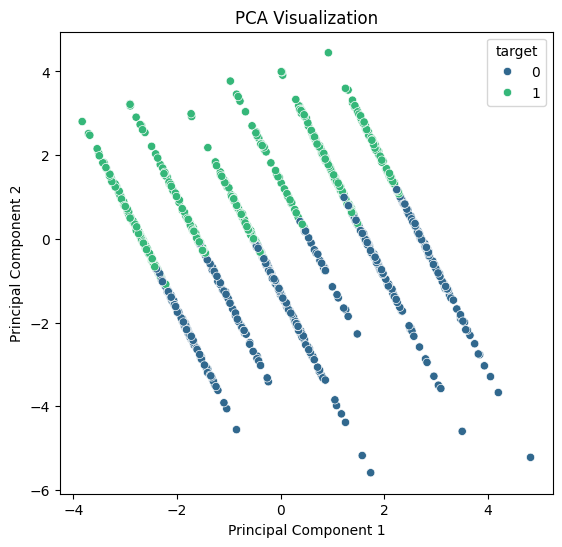

In [22]:
# Визуалізация PCA
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', legend='full')
plt.title('PCA Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

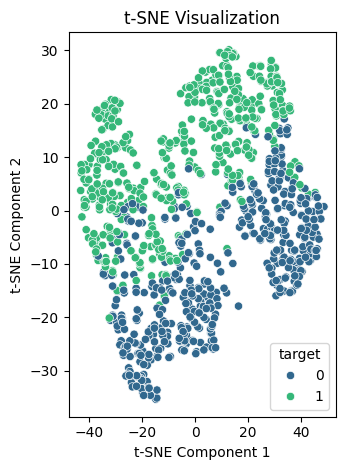

In [23]:
# Визуалізация t-SNE
plt.subplot(1, 2, 2)
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', legend='full')
plt.title('t-SNE Visualization')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

plt.tight_layout()
plt.show()

In [ ]:
# task 2

In [24]:
from PIL import Image
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Функція для квантування зображення
def quantize_image(image, k):
    # Перетворення зображення в двовимірний масив пікселів (RGB)
    pixels = np.array(image).reshape(-1, 3)
    
    # Використання k-means для квантування
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(pixels)
    
    # Замінюємо кольори пікселів центроїдами кластерів
    new_pixels = kmeans.cluster_centers_[kmeans.labels_]
    new_image = new_pixels.reshape(image.size[1], image.size[0], 3).astype(np.uint8)
    
    return Image.fromarray(new_image)


In [25]:
# Завантаження зображення через Pillow
image_path = 'hellokitty.jpg'  # Вкажіть шлях до вашого зображення
image = Image.open(image_path)

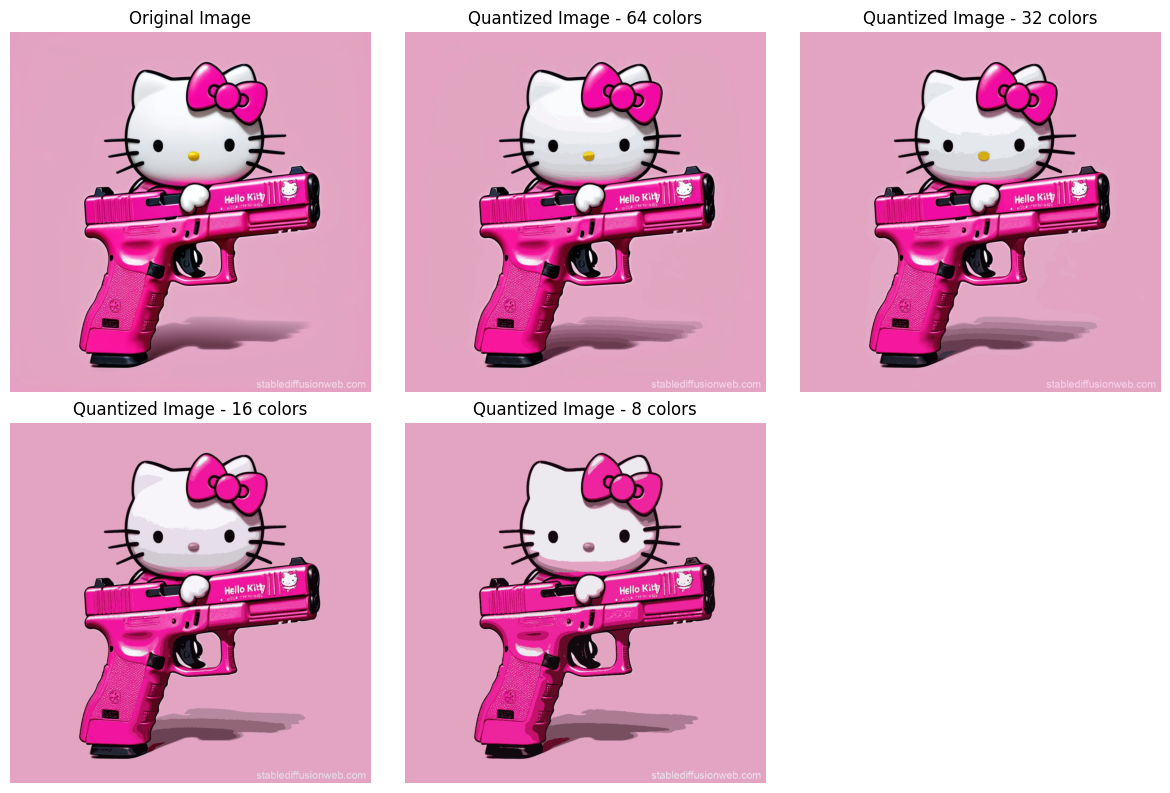

In [26]:
# Візуалізація оригінального зображення та квантування для різних рівнів
levels = [64, 32, 16, 8]

plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')

for i, k in enumerate(levels):
    quantized_image = quantize_image(image, k)
    plt.subplot(2, 3, i+2)
    plt.imshow(quantized_image)
    plt.title(f'Quantized Image - {k} colors')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# task 3

In [28]:
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Завантаження даних
data = pd.read_csv('../Emotion_classify_Data.csv', encoding='latin-1')
data = data[['Comment', 'Emotion']]
data.columns = ['text','label']

data.head

FileNotFoundError: [Errno 2] No such file or directory: 'Emotion_classify_Data.csv'

In [ ]:
# Передобробка тексту
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
print(stop_words)

def preprocess_text(text):
    # Видалення пунктуації і приведення до нижнього регістру
    text = re.sub(r'[^\w\s]', '', text.lower())
    # Видалення стоп-слів
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

data['text_clean'] = data['text'].apply(preprocess_text)
data['text_clean']

In [ ]:
# Візуалізація WordCloud для кожного класу
for label in data['label'].unique():
    subset = data[data['label'] == label]
    text = ' '.join(subset['text_clean'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud for {label}')
    plt.show()

In [ ]:
# Преобробка даних: заміна міток класів на числові
data['label'] = data['label'].map({'joy': 0, 'anger': 1, 'fear': 2})

# Векторизація тексту
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(data['text_clean'])
y = data['label']

# Розбиття даних на тренувальні та тестові набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Навчання класифікатора
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Прогнозування
y_pred = classifier.predict(X_test)

# Оцінка якості
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred, target_names=['joy', 'anger', 'fear']))